<font size="+3"><strong>Predicting Damage with Logistic Regression
</strong></font>

In [ ]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data
## Import

In [ ]:
def wrangle(db_path):
      # Connect to database
      conn = sqlite3.connect(db_path)
      # Construct query
      query = """
          select distinct (i.building_id) as b_id, s.*, d.damage_grade
          from id_maps as i
          join building_structure as s
          on i.building_id = s.building_id
          join building_damage as d
          on i.building_id = d.building_id
          where i.district_id = 36

      """

      # Read query results into DataFrame
      df = pd.read_sql(query, conn, index_col = "b_id")

      return df

In [ ]:
df = wrangle("nepal.db")
df.head()

,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,technical_solution_proposed,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,,
360106001171,360106001171,2,0,4,280,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble unclear,Reconstruction,"mud mortar ,stone",Grade 5
360106001181,360106001181,1,0,15,120,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,Damaged-Rubble unclear,Reconstruction,"mud mortar ,stone",Grade 5
360107000161,360107000161,2,0,25,300,14,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble unclear,Reconstruction,"mud mortar ,stone",Grade 5
360107000381,360107000381,2,0,22,155,16,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,Reconstruction,"mud mortar ,stone",Grade 5
360202000691,360202000691,2,0,20,240,14,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,Damaged-Rubble unclear,Reconstruction,"mud mortar ,stone",Grade 5


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63333 entries, 360106001171 to 365309000911
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   building_id                  63333 non-null  int64 
 1   count_floors_pre_eq          63333 non-null  int64 
 2   count_floors_post_eq         63333 non-null  int64 
 3   age_building                 63333 non-null  int64 
 4   plinth_area_sq_ft            63333 non-null  int64 
 5   height_ft_pre_eq             63333 non-null  int64 
 6   height_ft_post_eq            63333 non-null  int64 
 7   land_surface_condition       63333 non-null  object
 8   foundation_type              63333 non-null  object
 9   roof_type                    63333 non-null  object
 10  ground_floor_type            63333 non-null  object
 11  other_floor_type             63333 non-null  object
 12  position                     63333 non-null  object
 13  plan_configur

In [ ]:
# Drop this leakage features from dataframe
drop_cols= [col for col in df.columns if "post_eq" in col]

In [ ]:
"""

    We want to build a binary classification model, but our current target "damage_grade" has more than two categories.
    So we need to creates a new target column "severe_damage".

    For buildings where the "damage_grade" is Grade 4 or above, "severe_damage" should be 1. For
    all other buildings, "severe_damage" should be 0. Also, we must drop "damage_grade" to avoid leakage.

"""

df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
drop_cols.append("damage_grade")

In [ ]:
df.drop(columns= drop_cols, inplace= True)

In [ ]:
print(df["severe_damage"].value_counts())

1    39397
0    23936
Name: severe_damage, dtype: int64


## Explore

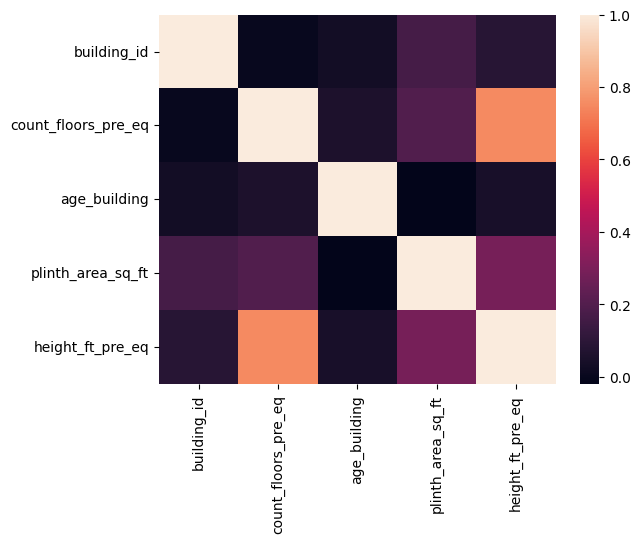

In [ ]:
# Plot a correlation heatmap of the remaining numerical features in df

# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

In [ ]:
# Drops the "count_floors_pre_eq" column

drop_cols.append("count_floors_pre_eq")

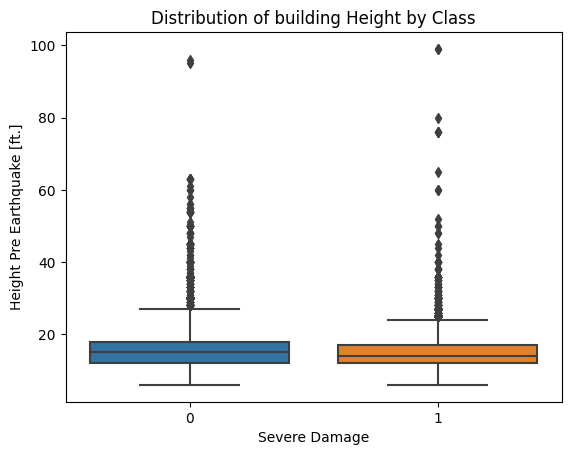

In [ ]:
# Create a boxplot that shows the distributions of the "height_ft_pre_eq" column for both groups in the "severe_damage" column

# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre Earthquake [ft.]")
plt.title("Distribution of building Height by Class");

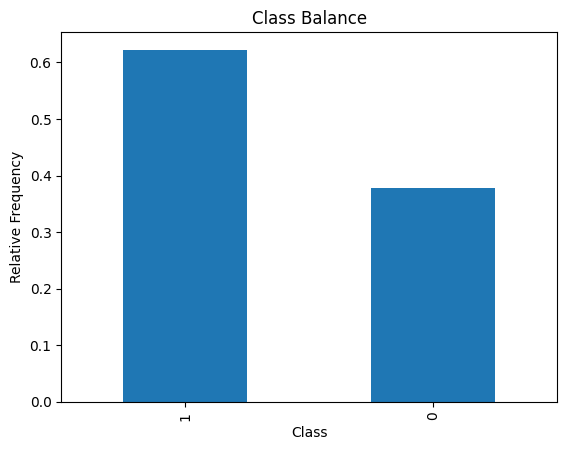

In [ ]:
# Check the balance between our two classes

# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

In [ ]:
"""
Create two variables, majority_class_prop and minority_class_prop, to store the
normalized value counts for the two classes in df["severe_damage"]
"""

majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6220611687429933 0.3779388312570066


In [ ]:
"""
 Are buildings with certain foundation types more likely to suffer severe damage?
Create a pivot table of df where the index is "foundation_type" and the values come from the
"severe_damage" column, aggregated by the mean.

"""

# Create pivot table
foundation_pivot = pd.pivot_table(
df, index= "foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by= "severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.024640
Bamboo/Timber,0.323676
Cement-Stone/Brick,0.370982
Mud mortar-Stone/Brick,0.676052
Other,0.809150


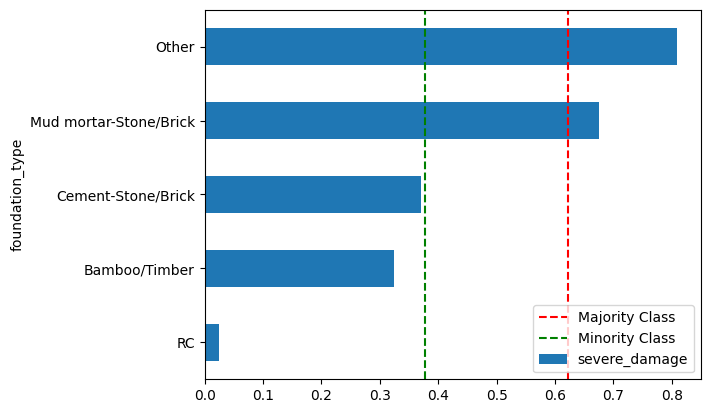

In [ ]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot( kind= "barh", legend=None)
plt.axvline(
majority_class_prop, linestyle="--", color="red", label="Majority Class"
)
plt.axvline(
minority_class_prop, linestyle="--", color="green", label="Minority Class"
)
plt.legend(loc= "lower right");

In [ ]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition          3
foundation_type                 5
roof_type                       3
ground_floor_type               5
other_floor_type                4
position                        4
plan_configuration             10
technical_solution_proposed     4
superstructure                 11
dtype: int64

**Final Version of Wrangle Function**

In [ ]:
def wrangle(db_path):
      # Connect to database
      conn = sqlite3.connect(db_path)
      # Construct query
      query = """
          select distinct (i.building_id) as b_id, s.*, d.damage_grade
          from id_maps as i
          join building_structure as s
          on i.building_id = s.building_id
          join building_damage as d
          on i.building_id = d.building_id
          where i.district_id = 36

      """

      # Read query results into DataFrame
      df = pd.read_sql(query, conn, index_col = "b_id")

      # Identify leaky columns
      drop_cols= [col for col in df.columns if "post_eq" in col]
      drop_cols.append("technical_solution_proposed")

      # Create binary target column
      df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
      df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

      # Drop old target
      drop_cols.append("damage_grade")

      # Drop multicollinearity column
      drop_cols.append("count_floors_pre_eq")

      # Add high-cardinality / redundant column
      drop_cols.append("building_id")

      # Drop columns
      df.drop(columns= drop_cols, inplace= True)


      return df

In [ ]:
df = wrangle("nepal.db")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63333 entries, 360106001171 to 365309000911
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            63333 non-null  int64 
 1   plinth_area_sq_ft       63333 non-null  int64 
 2   height_ft_pre_eq        63333 non-null  int64 
 3   land_surface_condition  63333 non-null  object
 4   foundation_type         63333 non-null  object
 5   roof_type               63333 non-null  object
 6   ground_floor_type       63333 non-null  object
 7   other_floor_type        63333 non-null  object
 8   position                63333 non-null  object
 9   plan_configuration      63333 non-null  object
 10  superstructure          63333 non-null  object
 11  severe_damage           63333 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 6.3+ MB
None


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
360106001171,4,280,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360106001181,15,120,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,"mud mortar ,stone",1
360107000161,25,300,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360107000381,22,155,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"mud mortar ,stone",1
360202000691,20,240,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,"mud mortar ,stone",1


## Split

In [ ]:
# Create our feature matrix X and target vector y
target = "severe_damage"
X = df.drop(columns = target)
y = df[target]

In [ ]:
# Divide our data (X and y) into training and test sets. Our test set 20% of our total data

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50666, 11)
y_train shape: (50666,)
X_test shape: (12667, 11)
y_test shape: (12667,)


# Build Model
## Baseline

In [ ]:
# Calculate the baseline accuracy score for our model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


## Iterate

In [ ]:
# Build model
model = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Evaluate

In [ ]:
# Calculate the training and test accuracy scores for our models

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.7
Test Accuracy: 0.71


# Communicate Results

In [ ]:
# Using the `.predict()` method with your model

y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.37407684 0.62592316]
 [0.32714599 0.67285401]
 [0.17237699 0.82762301]
 [0.26170357 0.73829643]
 [0.4236464  0.5763536 ]]


In [ ]:
model.predict(X_train)[:5]

array([1, 1, 1, 1, 1])

In [ ]:
# Extract the feature names and importances from our model

features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [ ]:
# Create a pandas Series named odds_ratios, where the index is features and the values are our the exponential of the importances

odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

foundation_type_RC                    0.242840
ground_floor_type_RC                  0.376628
roof_type_RCC/RB/RBC                  0.428344
foundation_type_Bamboo/Timber         0.520330
plan_configuration_Multi-projected    0.546680
dtype: float64

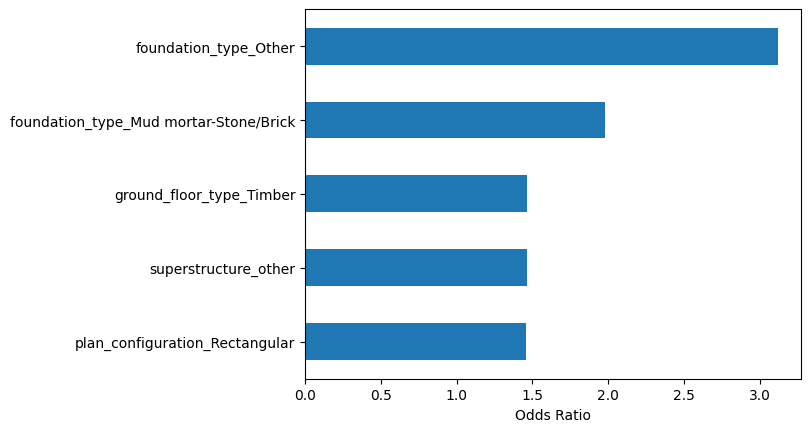

In [ ]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

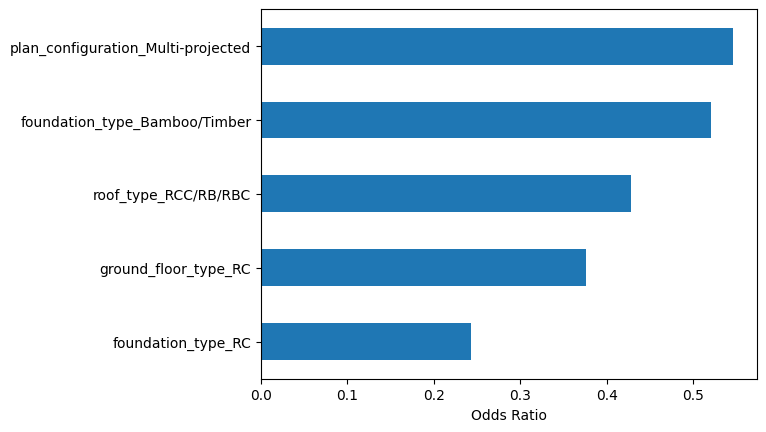

In [ ]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");